In [2]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline

Welcome to JupyROOT 6.12/06


In [4]:
f = r.TFile("./data/gm2offline_ana.root")
twest = f.Get("farline").Get("eventTree")
teast = f.Get("farline").Get("eastTree")
tcomp = f.Get("farline").Get("evwTree")
terr = f.Get("farline").Get("evwNoPartnerTree")

tcomp2 = f.Get("farline").Get("wveTree")
terr2 = f.Get("farline").Get("wveNoPartnerTree")

fwave = r.TFile("./data/waveforms.root")
twave = fwave.Get("islands").Get("islands").Get("islandTree")

In [5]:
from evwTools import *

Unique island:  1592100222000020000100050 (entry 0 )
     KS Result:  0.7862280082726261
0.7862280082726261
0.5493264419710108
0.998265735388435


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


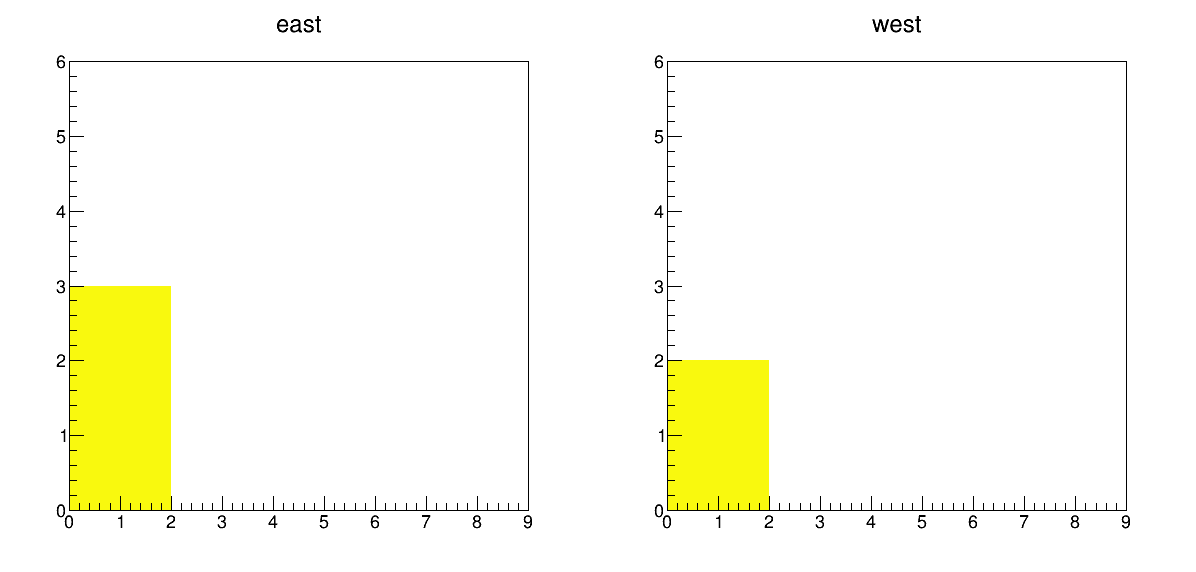

In [9]:
dingbefore = 0
ksVec = []

lowVec = []
highVec = []

fout = r.TFile("temp_tree_storage.root","recreate")

for i, entry in enumerate(teast):
    
    if i < 0:
        continue
    if i > 3:
        break
    
    counter = 0
    ding = constructUniqueIDeast(entry)
    if (dingbefore == ding):
        continue
        
    
    crystalsEast = [x for x in entry.crystalsEast]
    
    teast_partial = teast.CopyTree( constructConditionFromUniqueIDEast(ding) )
    for k, entry3 in enumerate(teast_partial):
        dong = constructUniqueIDeast(entry3)
        if ding == dong:
            crystalsEast += [x for x in entry3.crystalsEast]
    
    crystalsWest = []
    twest_partial = twest.CopyTree( constructConditionFromUniqueIDWest(ding) )
    for j, entry2 in enumerate(twest_partial):
        dong = constructUniqueIDwest(entry2)
        if (ding == dong):
            counter = counter + 1
            crystalsWest += [x for x in entry2.crystalsWest]
                    
    eastMap = toMap(crystalsEast)
    westMap = toMap(crystalsWest)
    idnum = ding

    dingbefore = ding

    h = r.TH2D("h","east",9,0,9,6,0,6)
    for iy, y in enumerate(eastMap):
        for ix, x in enumerate(y):
            if(x > 0.1):
                h.Fill(ix,iy)
    h2 = r.TH2D("h2","west",9,0,9,6,0,6)
    for iy, y in enumerate(westMap):
        for ix, x in enumerate(y):
            if(x > 0.1):
                h2.Fill(ix,iy)
                
    ksi = h.KolmogorovTest(h2)
    if((ksi < 0.5) or (i % 1000 == 0)):
        print("Unique island: ", ding, "(entry", i, ")")
        print("     KS Result: ", ksi)
    ksVec.append(ksi)
    
    print(ksi)
    
    if(ksi < 0.5):
        imshowCompare( toMap(crystalsEast), toMap(crystalsWest), True, ding)
        lowVec.append((ding, ksi))
        
    c = r.TCanvas("c","c",1200,600)
    c.Divide(2,1)
    c.cd(1)
    h.Draw("COL")
    c.cd(2)
    h2.Draw("COL")
    c.Draw()

In [ ]:
print(lowVec)

plt.plot(ksVec)
plt.show()

In [ ]:
plt.hist(ksVec,bins=50,range=(0,1))
plt.yscale('log')
plt.show()